Feature matrix shape: (1000, 20)
Target matrix shape: (1000, 5)
Sample 0 features:
 [3. 0. 2. 2. 2. 8. 3. 2. 5. 2. 0. 1. 0. 1. 0. 0. 6. 5. 0. 2.]
Sample 0 labels:
 [0 0 0 1 0]
Epoch    0 | train_loss=0.6889 | test_loss=0.6048 | F1µ=0.086 | F1M=0.057 | Hamming=0.360 | SubsetAcc=0.195
Epoch    1 | train_loss=0.6026 | test_loss=0.5703 | F1µ=0.217 | F1M=0.142 | Hamming=0.332 | SubsetAcc=0.285
Epoch  100 | train_loss=0.3857 | test_loss=0.3974 | F1µ=0.646 | F1M=0.581 | Hamming=0.208 | SubsetAcc=0.450
Epoch  200 | train_loss=0.3848 | test_loss=0.3954 | F1µ=0.662 | F1M=0.599 | Hamming=0.201 | SubsetAcc=0.460
Epoch  300 | train_loss=0.3890 | test_loss=0.3984 | F1µ=0.667 | F1M=0.598 | Hamming=0.200 | SubsetAcc=0.455
Epoch  400 | train_loss=0.3826 | test_loss=0.3959 | F1µ=0.657 | F1M=0.597 | Hamming=0.203 | SubsetAcc=0.465
Epoch  500 | train_loss=0.3848 | test_loss=0.3975 | F1µ=0.661 | F1M=0.588 | Hamming=0.203 | SubsetAcc=0.440
Epoch  600 | train_loss=0.3886 | test_loss=0.3963 | F1µ=0.674 | F1M=

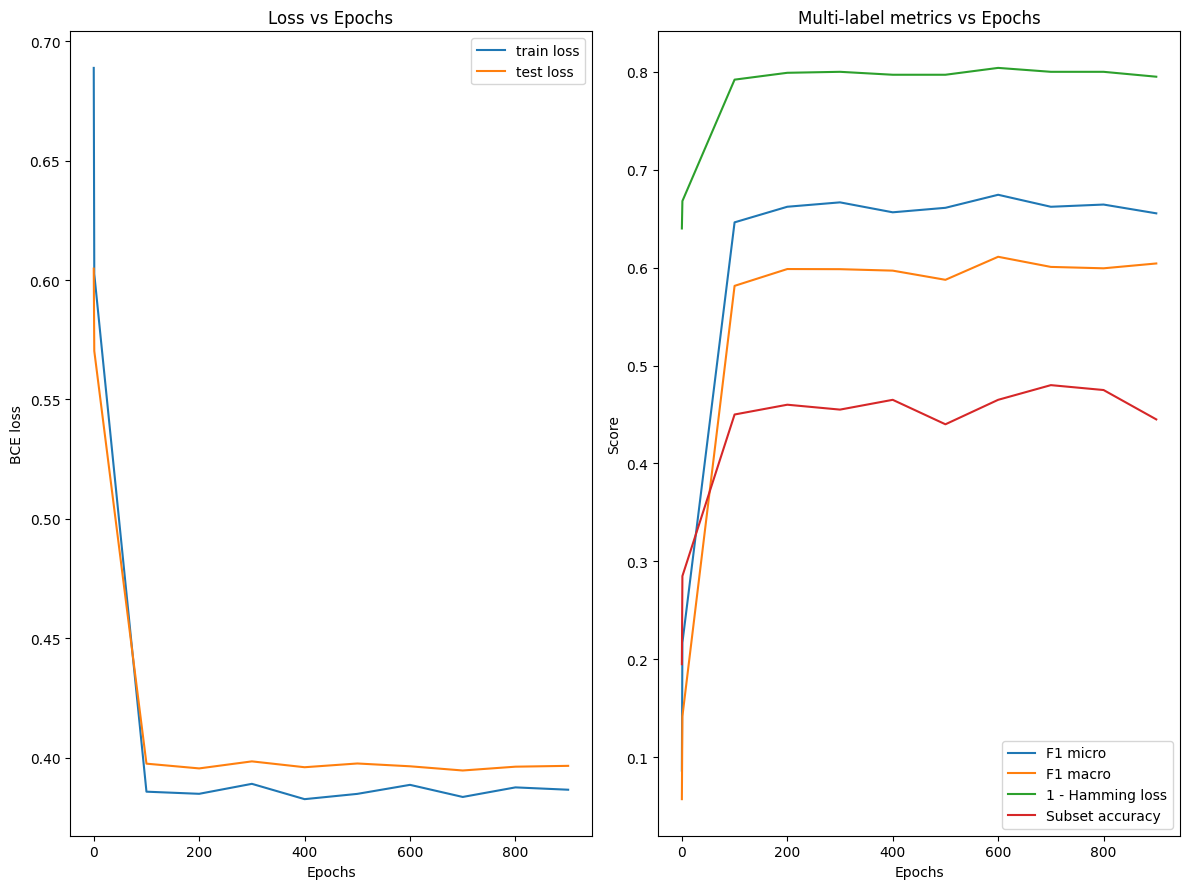

In [14]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_multilabel_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, hamming_loss, accuracy_score
import numpy as np


X, y = make_multilabel_classification(
    n_samples=1000,
    n_features=20,
    n_classes=5,
    n_labels=2,
    random_state=42
)


print("Feature matrix shape:", X.shape)   # (1000, 20)
print("Target matrix shape:", y.shape)    # (1000, 5)

# Check one sample
print("Sample 0 features:\n", X[0])
print("Sample 0 labels:\n", y[0])

X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_np = scaler.fit_transform(X_train_np)
X_test_np = scaler.transform(X_test_np)

device = "cuda" if torch.cuda.is_available() else "cpu"

X_train = torch.tensor(X_train_np, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test_np, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train_np, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test_np, dtype=torch.float32).to(device)

class MultiLabelClassifier(nn.Module):
    def __init__(self, in_dims, out_dims, hidden_1=256, hidden_2=128, dropout_rate=0.5):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dims, hidden_1),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Linear(hidden_1, hidden_2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Linear(hidden_2, out_dims)
        )

    def forward(self, x):
        return self.net(x)


model = MultiLabelClassifier(in_dims=len(X_train[0]), out_dims=len(y_train[0])).to(device)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-2)

# Training
EPOCHS = 1000
PRINT_EVERY = 100
epoch_count = []
f1_micro_hist, f1_macro_hist, hamming_hist, subset_acc_hist = [], [], [], []
training_loss, testing_loss = [], []

THRESHOLD = 0.6
for epoch in range(EPOCHS):
    model.train()
    logits = model(X_train)
    y_pred = (torch.sigmoid(logits).detach().numpy() >= THRESHOLD).astype(int)
    loss = loss_fn(logits, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Testing
    model.eval()
    with torch.inference_mode():
        test_logits = model(X_test)
        y_test_pred = (torch.sigmoid(test_logits).cpu().numpy() >= THRESHOLD).astype(int)
        test_loss = loss_fn(test_logits, y_test)

    if epoch % PRINT_EVERY == 0 or epoch == 1 or epoch == EPOCHS:
        # metrics
        f1_micro = f1_score(y_test, y_test_pred, average="micro", zero_division=0)
        f1_macro = f1_score(y_test, y_test_pred, average="macro", zero_division=0)
        hamming  = hamming_loss(y_test, y_test_pred)
        subset   = accuracy_score(y_test, y_test_pred)  # exact match

        epoch_count.append(epoch)
        training_loss.append(loss.item())
        testing_loss.append(test_loss.item())

        f1_micro_hist.append(f1_micro)
        f1_macro_hist.append(f1_macro)
        hamming_hist.append(hamming)
        subset_acc_hist.append(subset)
        print(f"Epoch {epoch:4d} | train_loss={loss:.4f} | test_loss={test_loss:.4f} "
              f"| F1µ={f1_micro:.3f} | F1M={f1_macro:.3f} | Hamming={hamming:.3f} | SubsetAcc={subset:.3f}")

# Final Evaluation
model.eval()
with torch.inference_mode():
    logits = model(X_test)
    y_pred = (torch.sigmoid(logits).cpu().numpy() >= THRESHOLD).astype(int)
    test_loss = loss_fn(logits, y_test)
    f1_micro = f1_score(y_test, y_pred, average="micro", zero_division=0)
    f1_macro = f1_score(y_test, y_pred, average="macro", zero_division=0)
    hamming  = hamming_loss(y_test, y_pred)
    subset   = accuracy_score(y_test, y_pred)  # exact match
    print(f"Final Evaluation | test_loss={test_loss:.4f} | F1µ={f1_micro:.3f} | F1M={f1_macro:.3f} | Hamming={hamming:.3f} | Subset={subset:.3f}")


# --- Plots
plt.figure(figsize=(12,9))
plt.subplot(1,2,1)
plt.plot(epoch_count, training_loss, label="train loss")
plt.plot(epoch_count, testing_loss, label="test loss")
plt.xlabel("Epochs"); plt.ylabel("BCE loss");
plt.title("Loss vs Epochs")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epoch_count, f1_micro_hist, label="F1 micro")
plt.plot(epoch_count, f1_macro_hist, label="F1 macro")
plt.plot(epoch_count, [1-h for h in hamming_hist], label="1 - Hamming loss")
plt.plot(epoch_count, subset_acc_hist, label="Subset accuracy")
plt.xlabel("Epochs");
plt.ylabel("Score");
plt.title("Multi-label metrics vs Epochs")
plt.legend()
plt.tight_layout()
plt.show()
